# Prepare Data

In [ ]:
#Import Google Drive to load the WGAN dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#remove existing dir, if any
!rm -rf /content/Dataset_WGAN

#Make new dirs
!mkdir /content/Dataset_WGAN
!mkdir /content/Dataset_WGAN/masks
!mkdir /content/Dataset_WGAN/images

#load and (quietly) extract the train files from Drive
!unzip -q /content/drive/MyDrive/Diplomityo/Dataset_WGAN/test_set.zip -d /content/Dataset_WGAN/
!cp /content/drive/MyDrive/Diplomityo/Dataset_WGAN/mean300.mat /content/Dataset_WGAN/
!cp /content/drive/MyDrive/Diplomityo/Dataset_WGAN/*.txt /content/Dataset_WGAN/

"""!unzip -q /content/drive/MyDrive/Diplomityo/Dataset_WGAN/train_set.zip -d /content/Dataset_WGAN/
!unzip -q /content/drive/MyDrive/Diplomityo/Dataset_WGAN/test_set.zip -d /content/Dataset_WGAN/
!cp /content/drive/MyDrive/Diplomityo/Dataset_WGAN/*.txt /content/Dataset_WGAN/
!cp /content/drive/MyDrive/Diplomityo/Dataset_WGAN/mean300.mat /content/Dataset_WGAN/
!cp /content/drive/MyDrive/Colab\ Notebooks/weather_git/TensorflowUtils.py /content
!mkdir /content/Dataset_WGAN/tfrecords"""

#!ls /content/Dataset_WGAN/

'!unzip -q /content/drive/MyDrive/Diplomityo/Dataset_WGAN/train_set.zip -d /content/Dataset_WGAN/\n!unzip -q /content/drive/MyDrive/Diplomityo/Dataset_WGAN/test_set.zip -d /content/Dataset_WGAN/\n!cp /content/drive/MyDrive/Diplomityo/Dataset_WGAN/*.txt /content/Dataset_WGAN/\n!cp /content/drive/MyDrive/Diplomityo/Dataset_WGAN/mean300.mat /content/Dataset_WGAN/\n!cp /content/drive/MyDrive/Colab\\ Notebooks/weather_git/TensorflowUtils.py /content\n!mkdir /content/Dataset_WGAN/tfrecords'

In [ ]:
"""Import libraries"""

#(quietly) install tensorflow examples to use pi2pix network model
!pip install -q git+https://github.com/tensorflow/examples.git

import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.io as sio
import matplotlib
import os
import pathlib
import time
import datetime
import glob
import tensorflow as tf
import cv2

from PIL import Image
from scipy import misc
from tensorflow import keras
from keras import layers
from IPython import display
from tensorflow_examples.models.pix2pix import pix2pix
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

tf.__version__
#Check if it runs on GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

""" Path and filenames """
root_path = "/content/Dataset_WGAN/"
dir_img = "/content/Dataset_WGAN/test_images/"
dir_mat = "/content/Dataset_WGAN/test_mats/"
image_save_dir = "/content/Dataset_WGAN/images/image"
mask_save_dir = "/content/Dataset_WGAN/masks"
seg_model_save_dir = "/content/drive/MyDrive/Diplomityo/Models/seg_model"
gen_model_save_dir = "/content/drive/MyDrive/Diplomityo/Models/gen_model"
att_model_save_dir = "/content/drive/MyDrive/Diplomityo/Models/att_model"
txtfile = root_path + 'test.txt'

ORIGINAL_HEIGHT = 300
ORIGINAL_WIDTH = 300

meanfile = sio.loadmat(root_path + 'mean300.mat')
meanvalue = meanfile['mean'] #mean value of images in training set

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.
Num GPUs Available:  1


{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Jun 15 15:23:15 2017', '__version__': '1.0', '__globals__': [], 'seg_mask': array([[5, 5, 5, ..., 4, 4, 4],
       [5, 5, 5, ..., 4, 4, 4],
       [5, 5, 5, ..., 4, 4, 4],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}
<class 'numpy.ndarray'>
(300, 300)
5
[[5 5 5 ... 4 4 4]
 [5 5 5 ... 4 4 4]
 [5 5 5 ... 4 4 4]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


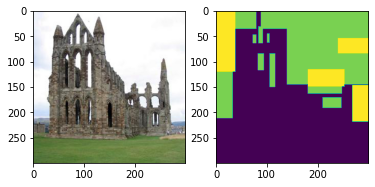

In [ ]:
"""Test the files by visualizing one image and mask"""

img = plt.imread(dir_img + "/cloudy_3004.jpg")
mask = sio.loadmat(dir_mat + "/cloudy_mask_3004.mat")

print(mask)

mask = mask["seg_mask"]

print(type(mask))
print(mask.shape)
print(mask[0][0])
print(mask)

#img_raw = img.tobytes()
#mask_raw = mask.tobytes()

#mask1 = np.fromstring(mask_raw, dtype=np.float64)
example_img = img.reshape((ORIGINAL_HEIGHT, ORIGINAL_WIDTH, -1))
example_img = example_img #+ meanvalue
example_mask = mask.reshape((ORIGINAL_HEIGHT, ORIGINAL_WIDTH))

plt.subplot(1,2,1)
plt.imshow(np.uint8(example_img))
plt.subplot(1,2,2)
plt.imshow(np.uint8(example_mask))

In [ ]:
images = []
masks = []

image_index = 0

"""read lines in the filenames .txt 
The format is "imageXXXX.jpg maskXXXX.mat category"
"""

reader = open(txtfile)
for i in reader.readlines():
    """if image_index > 999:
      break"""
    item = i.split()

    img = cv2.imread(dir_img + item[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(tf.convert_to_tensor(img)) 

    maskmat = sio.loadmat(dir_mat + item[1])
    mask = tf.convert_to_tensor(maskmat["seg_mask"])
    masks.append(mask)   

    image_index += 1

reader.close()

<class 'list'>
1000
<class 'list'>
1000


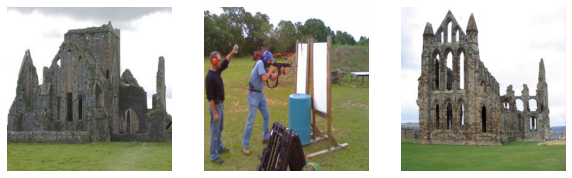

In [ ]:
print(type(masks))
print(len(masks))

print(type(images))
print(len(images))

plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = images[i]
    plt.imshow(img, cmap="jet")
    plt.axis("off")
plt.show()

In [ ]:
print(images[0].numpy().min(), images[0].numpy().max())
masks[0].numpy().min(), masks[0].numpy().max()

0 255


(0, 3)

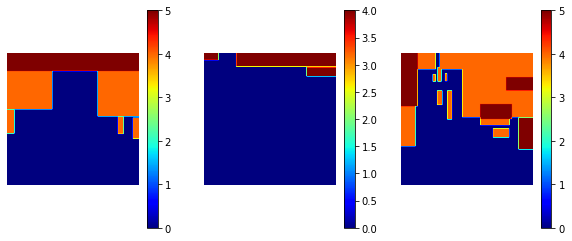

In [ ]:
plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = masks[i]
    plt.imshow(img, cmap="jet")
    plt.colorbar()
    plt.axis("off")
plt.show()

# Generator model (CycleGAN)

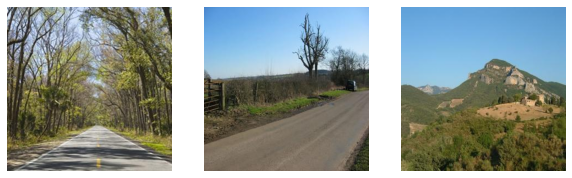

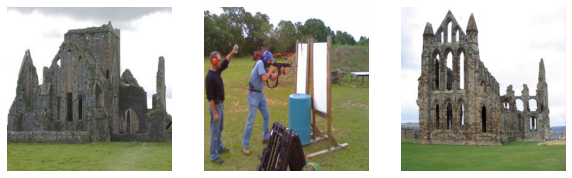

In [ ]:
"""Make a dataset of cloudy - sunny categories"""

sunny_images = []
cloudy_images = []

image_index = 0

reader = open(txtfile)
for i in reader.readlines():
    """    if image_index > 999:
      break"""
    item = i.split()

    img = cv2.imread(dir_img + item[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if "sunny" in item[0]:
      sunny_images.append(tf.convert_to_tensor(img))

    else:
      cloudy_images.append(tf.convert_to_tensor(img))

    image_index = image_index + 1

reader.close()

plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = sunny_images[i]
    plt.imshow(img, cmap="jet")
    #plt.colorbar()
    plt.axis("off")
plt.show()

plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = cloudy_images[i]
    plt.imshow(img, cmap="jet")
    #plt.colorbar()
    plt.axis("off")
plt.show()

sunny_images = np.array(sunny_images)
cloudy_images = np.array(cloudy_images)

In [ ]:
print(len(sunny_images))
print(len(cloudy_images))

In [ ]:
AT= tf.data.AUTOTUNE

BUFFER = 100
BATCH_SIZE = 8
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 3
LAMBDA = 10

"""Use the CycleGAN style pix2pix GAN model"""
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type="instancenorm")
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type="instancenorm")

discriminator_x = pix2pix.discriminator(norm_type="instancenorm", target=False)
discriminator_y = pix2pix.discriminator(norm_type="instancenorm", target=False)

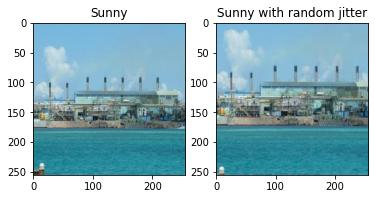

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def resize(image):
  image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return image

def random_jitter(image):
  image = tf.image.resize(image, [300, 300],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

def preprocess_image_train(image):
  image = random_jitter(image)
  image = normalize(image)
  return image

def preprocess_image_test(image):
  image = normalize(image)
  image = resize(image)
  return image

"""Create train and val sets"""

sunny_images_X, cloudy_images_X, sunny_images_y, cloudy_images_y = train_test_split(sunny_images, cloudy_images, 
                                                      test_size=0.2, 
                                                      random_state=0
                                                     )
sunny_images_X = tf.data.Dataset.from_tensor_slices(sunny_images_X)
cloudy_images_X = tf.data.Dataset.from_tensor_slices(cloudy_images_X)

sunny_images_y = tf.data.Dataset.from_tensor_slices(sunny_images_y)
cloudy_images_y = tf.data.Dataset.from_tensor_slices(cloudy_images_y)

train_sunny = sunny_images_X.cache().map(
    preprocess_image_train, num_parallel_calls=AT).shuffle(
    BUFFER).batch(BATCH_SIZE)

train_cloudy = cloudy_images_y.cache().map(
    preprocess_image_train, num_parallel_calls=AT).shuffle(
    BUFFER).batch(BATCH_SIZE)

val_sunny = sunny_images_y.map(
    preprocess_image_test, num_parallel_calls=AT).cache().shuffle(
    BUFFER).batch(BATCH_SIZE)

val_cloudy = cloudy_images_y.map(
    preprocess_image_test, num_parallel_calls=AT).cache().shuffle(
    BUFFER).batch(BATCH_SIZE)

sample_sunny = next(iter(train_sunny))
sample_cloudy = next(iter(train_cloudy))

plt.subplot(121)
plt.title("Sunny")
plt.imshow(sample_sunny[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title("Sunny with random jitter")
plt.imshow(random_jitter(sample_sunny[0]) * 0.5 + 0.5)

(8, 256, 256, 3)
(8, 256, 256, 3)


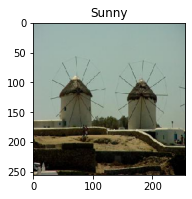

In [ ]:
test_cloudy = next(iter(val_cloudy))
plt.subplot(121)
plt.title("Sunny")
plt.imshow(test_cloudy[0] * 0.5 + 0.5)

print(sample_cloudy.shape)
print(test_cloudy.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


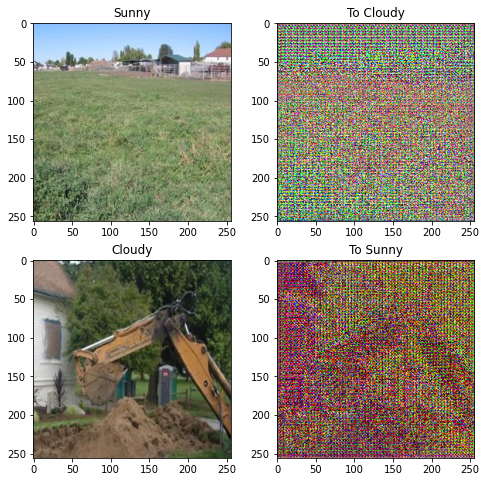

In [ ]:
to_sunny = generator_g(sample_sunny)
to_cloudy = generator_f(sample_cloudy)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_sunny, to_sunny, sample_cloudy, to_cloudy]
title = ["Sunny", "To Cloudy", "Cloudy", "To Sunny"]

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def perceptual_loss():
  perceptual_loss = 1

  return perceptual_loss

def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ("Latest checkpoint restored!")

In [ ]:
EPOCHS = 20

def generate_images(model, input_img, prediction_text="Predicted Image"):
  prediction = model(input_img)
    
  plt.figure(figsize=(12, 12))

  display_list = [input_img[0], prediction[0]]
  title = ["Input Image", prediction_text]

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])

    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis("off")
  plt.show()

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

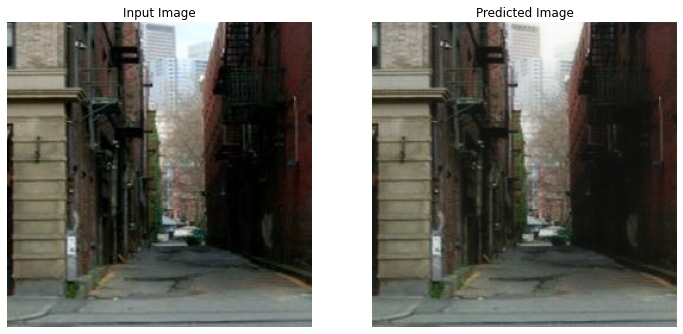

Saving checkpoint for epoch 20 at ./checkpoints/train/ckpt-4
Time taken for epoch 20 is 164.13730144500732 sec



In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  #n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_sunny, train_cloudy)):
    train_step(image_x, image_y)
    """if n % 10 == 0:
      #print (".", end="")
    n += 1"""

  clear_output(wait=True)

  generate_images(generator_g, sample_cloudy)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ("Saving checkpoint for epoch {} at {}".format(epoch+1,
                                                         ckpt_save_path))

  print ("Time taken for epoch {} is {} sec\n".format(epoch + 1,
                                                      time.time()-start))

In [ ]:
#keras.utils.plot_model(generator_g, show_shapes=True)
#keras.models.save_model(model=generator_g, filepath=gen_model_save_dir)
generator_g = keras.models.load_model(filepath=gen_model_save_dir)

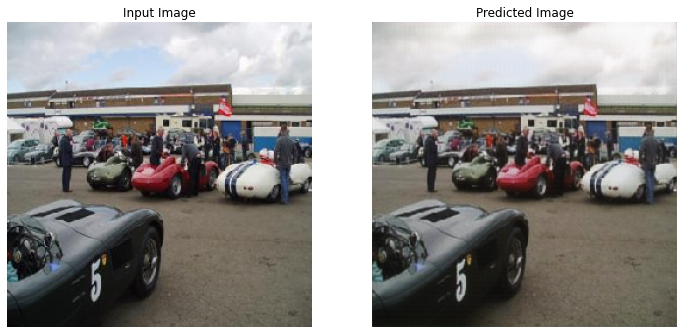

In [ ]:
#test_cloudy = test_cloudy.reshape(-1, 256, 256, 3)

#test_sunny = next(iter(val_sunny))

#for inp in test_cloudy:
generate_images(generator_g, test_sunny)

In [ ]:
# Run the trained model on the test dataset

inp = next(iter(val_cloudy))

prediction = generator_g(inp)
    
plt.figure(figsize=(12, 12))

#display_list = [input_img[0], prediction[0]]
title = ["Input Image", "Predicted image"]

for i in range(2):
  plt.subplot(1, 2, i+1)
  plt.title(title[i])

  plt.imshow(prediction * 0.5 + 0.5)
  plt.axis("off")
plt.show()

#generate_images(generator_g, inp)

# Segmentation model (with VGG19 256x256x3)

In [ ]:
vgg_org = keras.applications.VGG19(input_shape=[256,256,3], 
                                      include_top=False, 
                                      weights="imagenet")

Plot the original VGG19 model

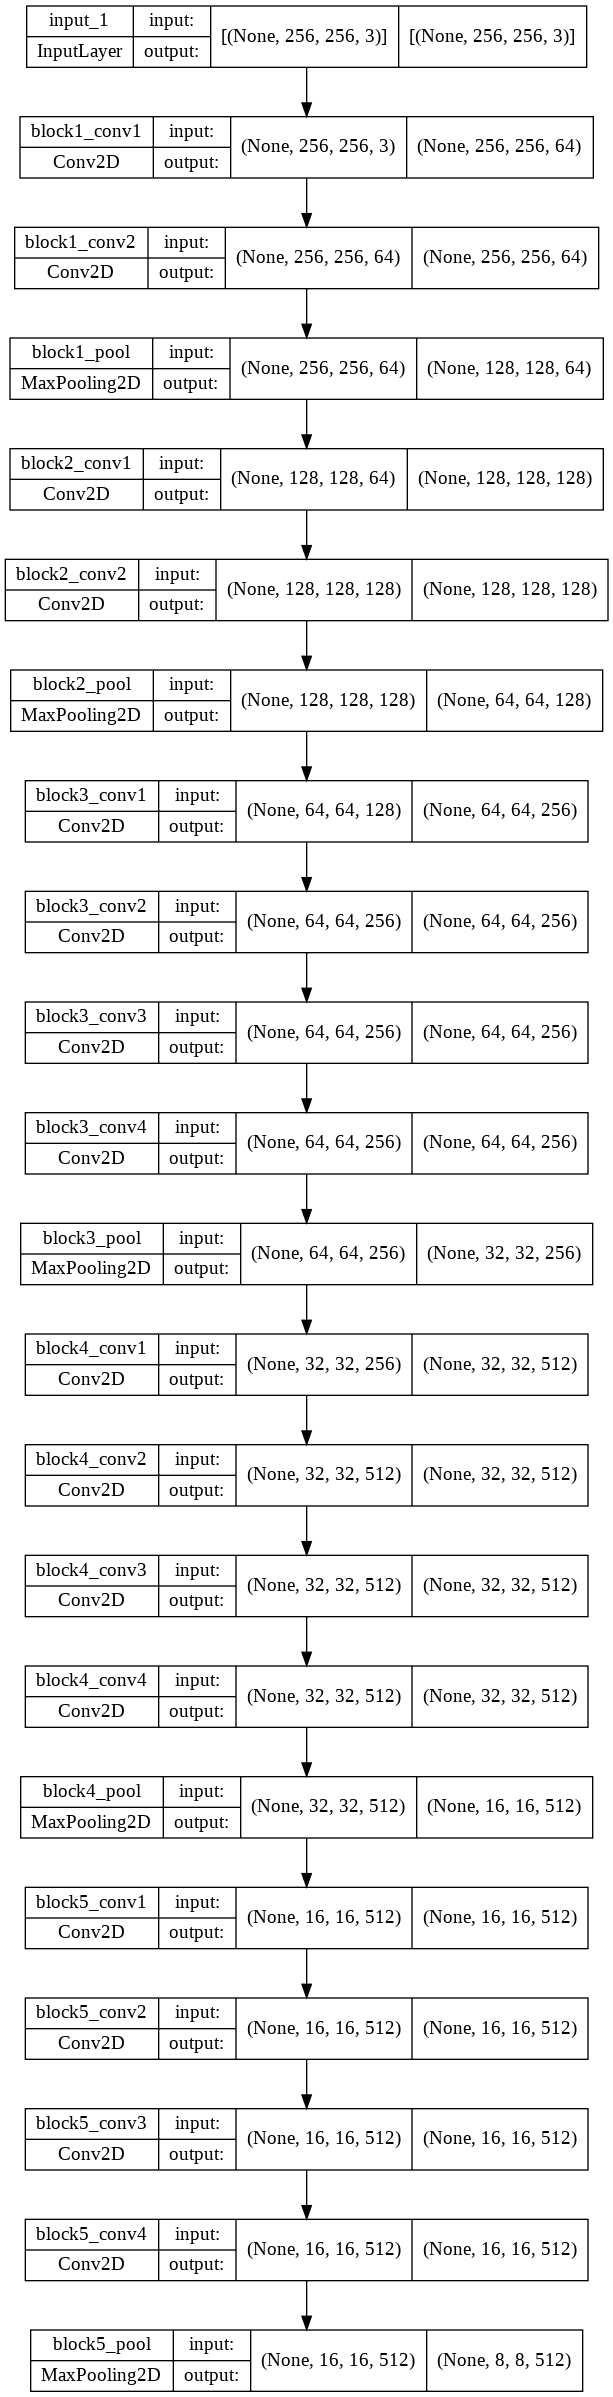

In [ ]:
keras.utils.plot_model(vgg_org, show_shapes=True)

Model definition

In [ ]:
"""Input layer
I'm using 256x256x3 instead of the original 300x300x3 of the data, since powers of two seemed to work better for UNET-model."""
input = keras.layers.Input(shape=[256,256,3])

"""Downstack names from VGG19"""
downstack_layers = ["block1_conv1", 
             "block1_pool",                
             "block2_pool", 
             "block3_pool",  
             "block4_pool",  
             "block5_pool"
             ]

"""Upstack layers from pix2pix"""
upstack_layers = [pix2pix.upsample(1024,3),
          pix2pix.upsample(512,3),
          pix2pix.upsample(256,3),
          pix2pix.upsample(128,3)]#,
          #pix2pix.upsample(64,3)]

"""Get the list of skip connections outputs"""
skip_outputs = [vgg_org.get_layer(x).output for x in downstack_layers]
for i in range(len(skip_outputs)):
    print(skip_outputs[i])      

"""Initialize the downstack model"""
downstack = keras.Model(inputs=vgg_org.input,
                       outputs=skip_outputs)
downstack.trainable = False     

"""Create the downstack hierarchy"""
encoder = downstack(input)
layer_out = encoder[-1]
skip_connections = reversed(encoder[:-1])

"""Map the skip connections"""
for decoder, skip in zip(upstack_layers, skip_connections):
    layer_out = decoder(layer_out)
    layer_out = keras.layers.Concatenate()([layer_out, skip])
    
"""6 classed output (1-5 weather categories + 0 as none)"""
output = keras.layers.Conv2DTranspose(6, 3,
                                  strides=2,
                                  padding="same",
                                  )(layer_out)

"""Combine the connections"""
seg_model = keras.Model(inputs=input, outputs=output)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 64), dtype=tf.float32, name=None), name='block1_conv1/Relu:0', description="created by layer 'block1_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 64), dtype=tf.float32, name=None), name='block1_pool/MaxPool:0', description="created by layer 'block1_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 128), dtype=tf.float32, name=None), name='block2_pool/MaxPool:0', description="created by layer 'block2_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 256), dtype=tf.float32, name=None), name='block3_pool/MaxPool:0', description="created by layer 'block3_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 512), dtype=tf.float32, name=None), name='block4_pool/MaxPool:0', description="created by layer 'block4_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")


Plot the modified model

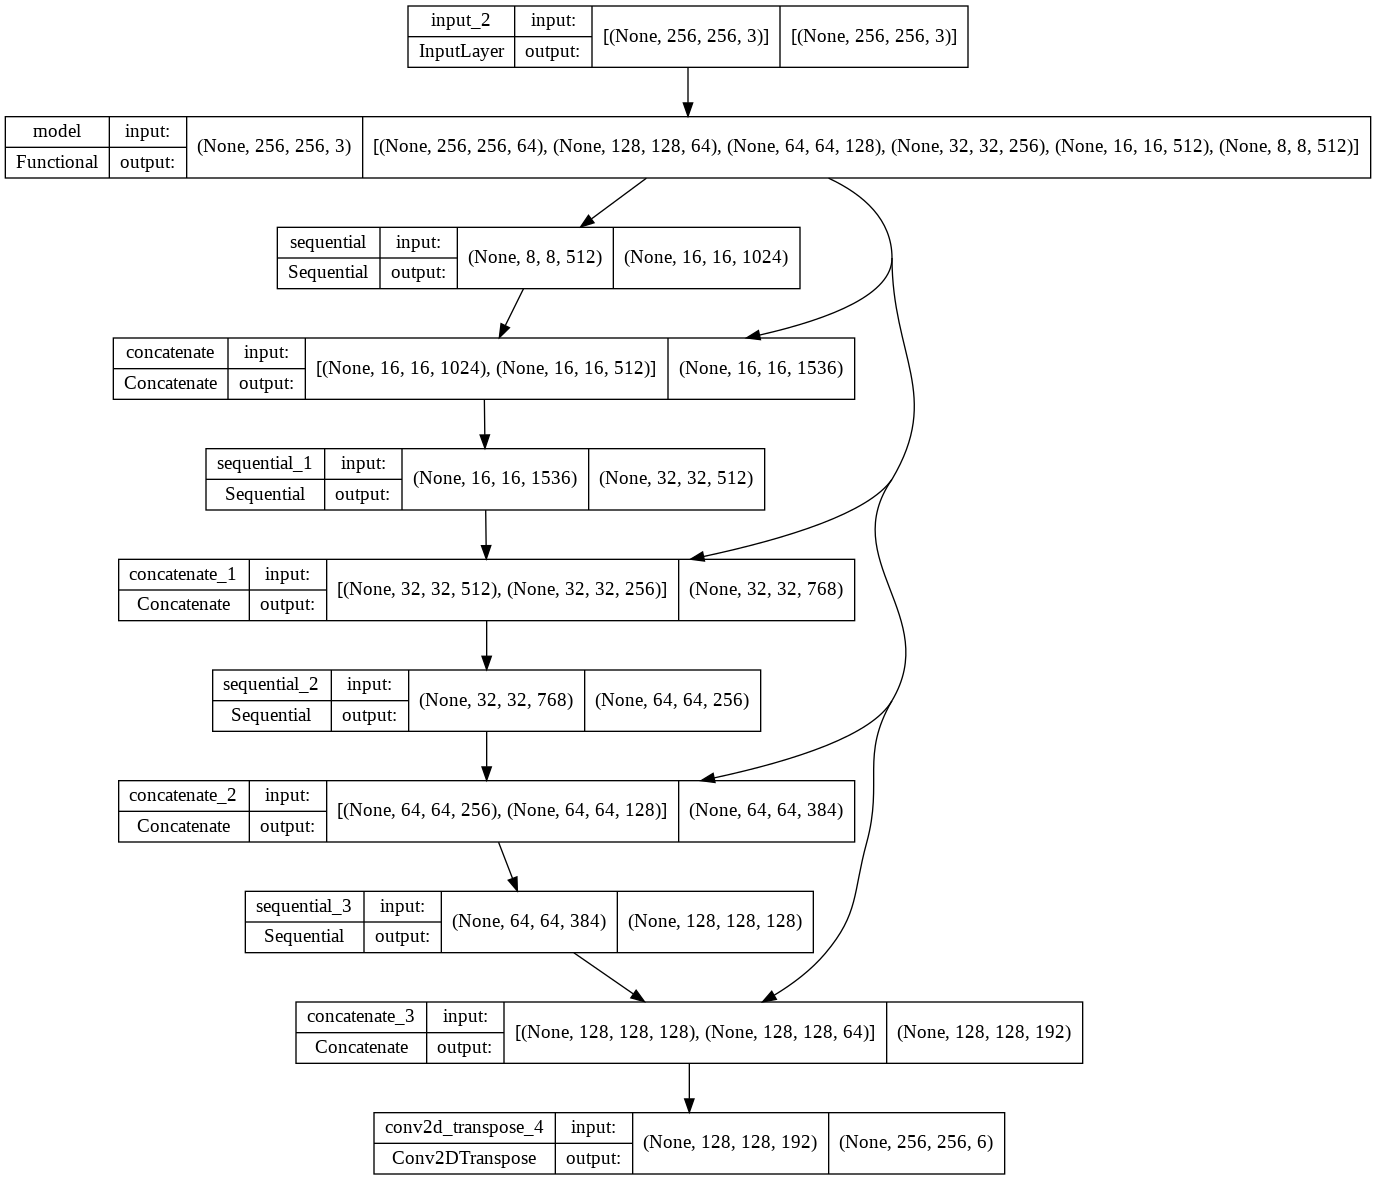

In [ ]:
keras.utils.plot_model(seg_model, show_shapes=True)

Preprocessing functions

In [ ]:
def resize_image(image):
    image = tf.cast(image, tf.float32)
    image = image/255.0
    # resize image
    image = tf.image.resize(image, (256,256))
    return image

def resize_mask(mask):
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (256,256))
    mask = tf.cast(mask, tf.uint8)
    return mask    

In [ ]:
X = [resize_image(i) for i in images]
y = [resize_mask(m) for m in masks]

#X, y = [preprocess_image_mask(i, j) for i, j in zip(images, masks)]

#X = np.asarray(X[:,0], dtype=np.float32)

In [ ]:
images[0].dtype, masks[0].dtype, X[0].dtype, y[0].dtype

(tf.uint8, tf.uint8, tf.float32, tf.uint8)

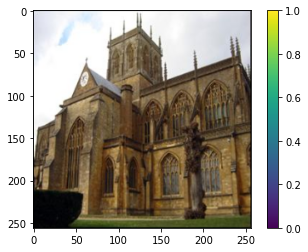

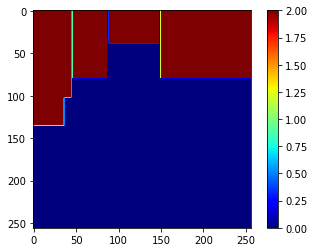

In [ ]:
plt.imshow(X[125])
plt.colorbar()
plt.show()

plt.imshow(y[125][:,:,0], cmap="jet")
plt.colorbar()
plt.show()

In [ ]:
def brightness(img, mask):
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

def gamma(img, mask):
    img = tf.image.adjust_gamma(img, 0.1)
    return img, mask

def hue(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

def crop(img, mask):
    img = tf.image.central_crop(img, 0.7)
    img = tf.image.resize(img, (256,256))
    mask = tf.image.central_crop(mask, 0.7)
    mask = tf.image.resize(mask, (256,256))
    mask = tf.cast(mask, tf.uint8)
    return img, mask

def rotate(img, mask):
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask

def flip_horizontal(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

def flip_vertical(img, mask):
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    return img, mask

def preprocess_image_mask(img, mask):
    img = tf.cast(img, tf.float32)
    mask = tf.expand_dims(mask, axis=-1)
    #img = resize_image(img)
    #mask = resize_mask(mask)
    img, mask = gamma(img, mask)
    img, mask = hue(img, mask)
    img, mask = brightness(img, mask)
    img, mask = crop(img, mask)
    img, mask = flip_horizontal(img, mask)
    img, mask = flip_vertical(img, mask)   
    img, mask = rotate(img, mask)

    return img, mask

Create the datasets

In [ ]:
train_X, val_X,train_y, val_y = train_test_split(X,y, 
                                                      test_size=0.2, 
                                                      random_state=0
                                                     )
train_X = tf.data.Dataset.from_tensor_slices(train_X)
val_X = tf.data.Dataset.from_tensor_slices(val_X)

train_y = tf.data.Dataset.from_tensor_slices(train_y)
val_y = tf.data.Dataset.from_tensor_slices(val_y)

train_X.element_spec, train_y.element_spec, val_X.element_spec, val_y.element_spec

#train = tf.data.Dataset.zip((train_X, train_y))
#val = tf.data.Dataset.zip((val_X, val_y))

(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))

In [ ]:
train = tf.data.Dataset.zip((train_X, train_y))
val = tf.data.Dataset.zip((val_X, val_y))

# perform augmentation on train data only

a = train.map(brightness)
b = train.map(gamma)
c = train.map(hue)
d = train.map(crop)
e = train.map(flip_horizontal)
f = train.map(flip_vertical)
g = train.map(rotate)

train = train.concatenate(a)
train = train.concatenate(b)
train = train.concatenate(c)
train = train.concatenate(d)
train = train.concatenate(e)
train = train.concatenate(f)
train = train.concatenate(g)

In [ ]:
BATCH = 64
AT = tf.data.AUTOTUNE
BUFFER = 1000

STEPS_PER_EPOCH = 800//BATCH
VALIDATION_STEPS = 200//BATCH

In [ ]:
train = train.cache().shuffle(BUFFER).batch(BATCH).repeat()
train = train.prefetch(buffer_size=AT)
val = val.batch(BATCH)

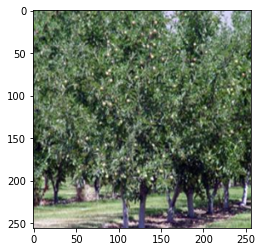

In [ ]:
example = next(iter(train))
preds = seg_model(example[0])
plt.imshow(example[0][0])
plt.show()

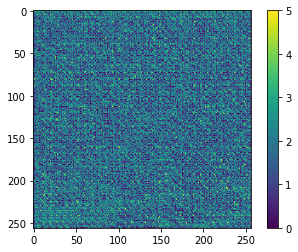

In [ ]:
pred_mask = tf.argmax(preds, axis=-1)
pred_mask = tf.expand_dims(pred_mask, -1)
plt.imshow(pred_mask[0][:,:,0])
plt.colorbar()

Compile and train

In [ ]:
seg_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=["accuracy"]) 

In [ ]:
hist = seg_model.fit(train,
               validation_data=val,
               steps_per_epoch=STEPS_PER_EPOCH,
               validation_steps=VALIDATION_STEPS,
               epochs=10)

Epoch 1/10
12/12 [==============================] - 57s 3s/step - loss: 0.8257 - accuracy: 0.7549 - val_loss: 0.8349 - val_accuracy: 0.8651
Epoch 2/10
12/12 [==============================] - 34s 3s/step - loss: 0.5068 - accuracy: 0.8402 - val_loss: 0.6658 - val_accuracy: 0.8550
Epoch 3/10
12/12 [==============================] - 34s 3s/step - loss: 0.4685 - accuracy: 0.8579 - val_loss: 0.5177 - val_accuracy: 0.8735
Epoch 4/10
12/12 [==============================] - 34s 3s/step - loss: 0.4379 - accuracy: 0.8637 - val_loss: 0.4511 - val_accuracy: 0.8753
Epoch 5/10
12/12 [==============================] - 34s 3s/step - loss: 0.4027 - accuracy: 0.8668 - val_loss: 0.4979 - val_accuracy: 0.8587
Epoch 6/10
12/12 [==============================] - 34s 3s/step - loss: 0.4312 - accuracy: 0.8663 - val_loss: 0.5024 - val_accuracy: 0.8548
Epoch 7/10
12/12 [==============================] - 34s 3s/step - loss: 0.4415 - accuracy: 0.8579 - val_loss: 0.4103 - val_accuracy: 0.8744
Epoch 8/10
12/12 [==

Visualize model predictions

In [ ]:
#keras.models.save_model(model=seg_model, filepath=seg_model_save_dir)
#seg_model = keras.models.load_model(filepath=seg_model_save_dir)

for images, labels in val.take(1):  # take elements from the dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

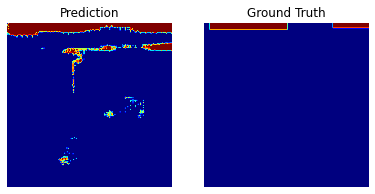

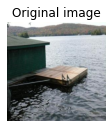

"plt.figure(figsize=(10,4))\nfor i in range(1,4):\n    plt.subplot(1,3,i)\n    img = images[i]\n    plt.imshow(img, cmap='jet')\n    plt.colorbar()\n    plt.axis('off')\nplt.show()"

In [ ]:
img, mask = next(iter(val))
predict = seg_model.predict(numpy_images)
plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
i = tf.argmax(predict[1], axis=-1)
plt.imshow(i,cmap="jet")
plt.axis("off")
plt.title("Prediction")

plt.subplot(1,3,2)
plt.imshow(numpy_labels[1][:,:,0], cmap="jet")
plt.axis("off")
plt.title("Ground Truth")
plt.show()

plt.subplot(1,3,3)
plt.imshow(numpy_images[1], cmap="jet")
plt.axis("off")
plt.title("Original image")
plt.show()

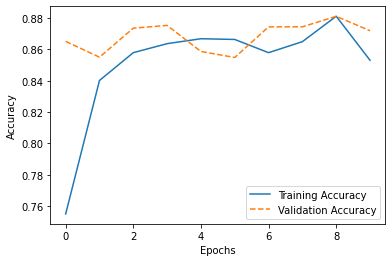

In [ ]:
history = hist.history
acc=history["accuracy"]
val_acc = history["val_accuracy"]

plt.plot(acc, "-", label="Training Accuracy")
plt.plot(val_acc, "--", label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Attention model (Not finished)

In [ ]:
attention_masks = np.array(masks)

for i in attention_masks:
  i[i > 1] = 1

In [ ]:
print(images[0].numpy().min(), images[0].numpy().max())
attention_masks[0].min(), attention_masks[0].max()

0 255


(0, 1)

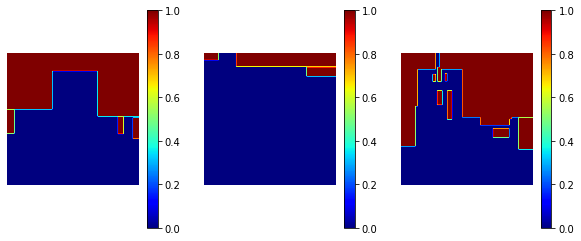

In [ ]:
plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = attention_masks[i]
    plt.imshow(img, cmap='jet')
    plt.colorbar()
    plt.axis('off')
plt.show()

In [ ]:
vgg_att_org = keras.applications.VGG19(input_shape=[256,256,3], 
                                      include_top=False, 
                                      weights='imagenet')

80150528/80134624 [==============================] - 1s 0us/step


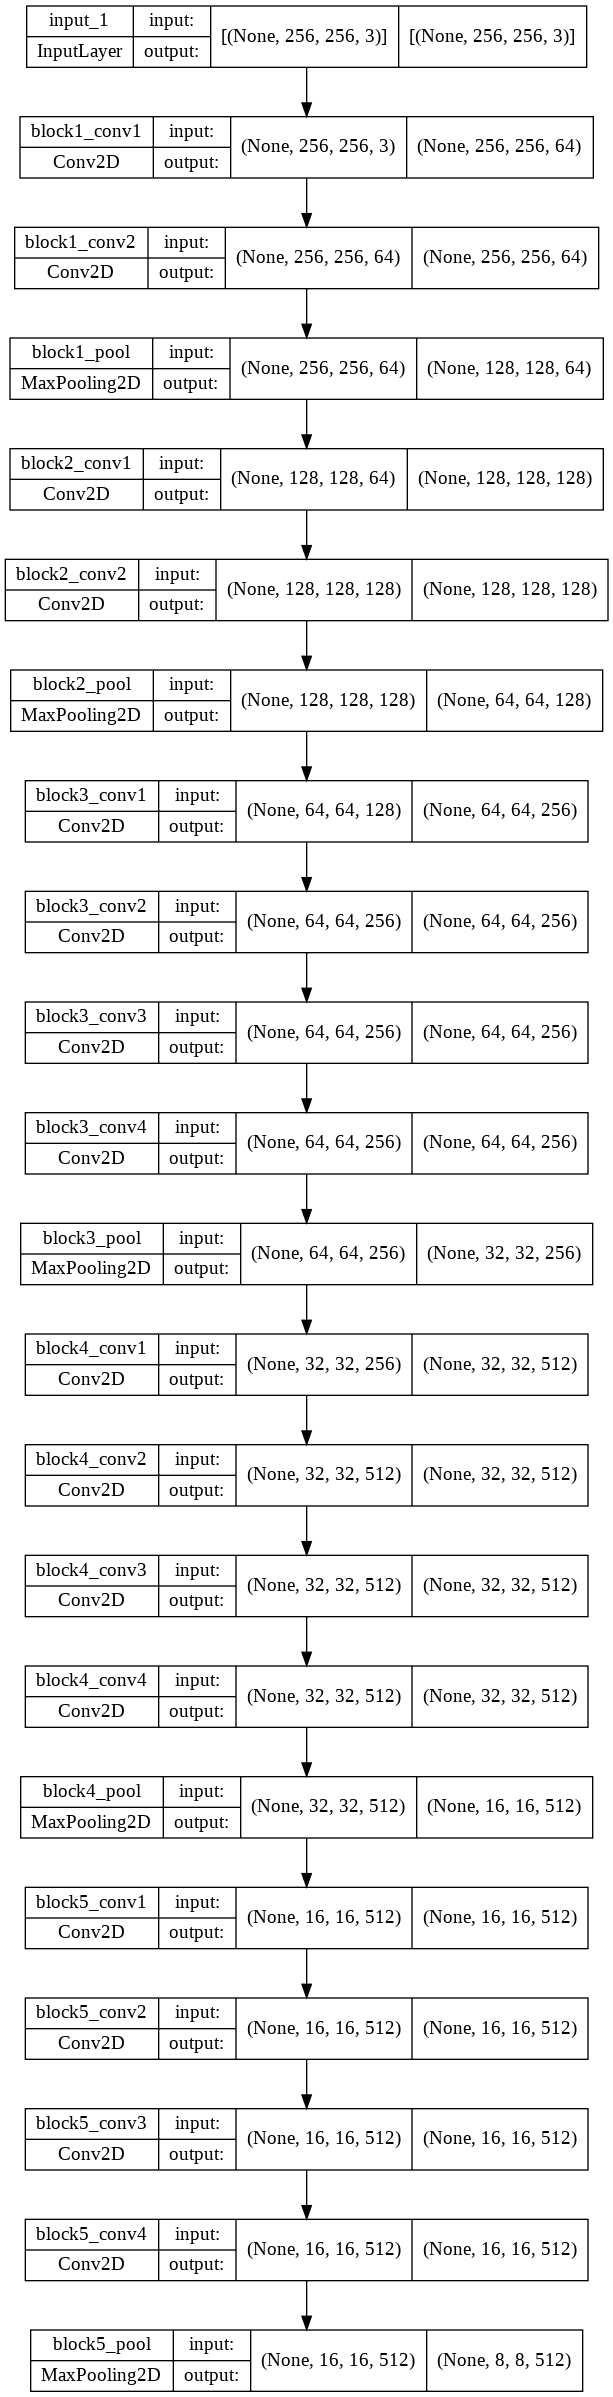

In [ ]:
keras.utils.plot_model(vgg_org, show_shapes=True)

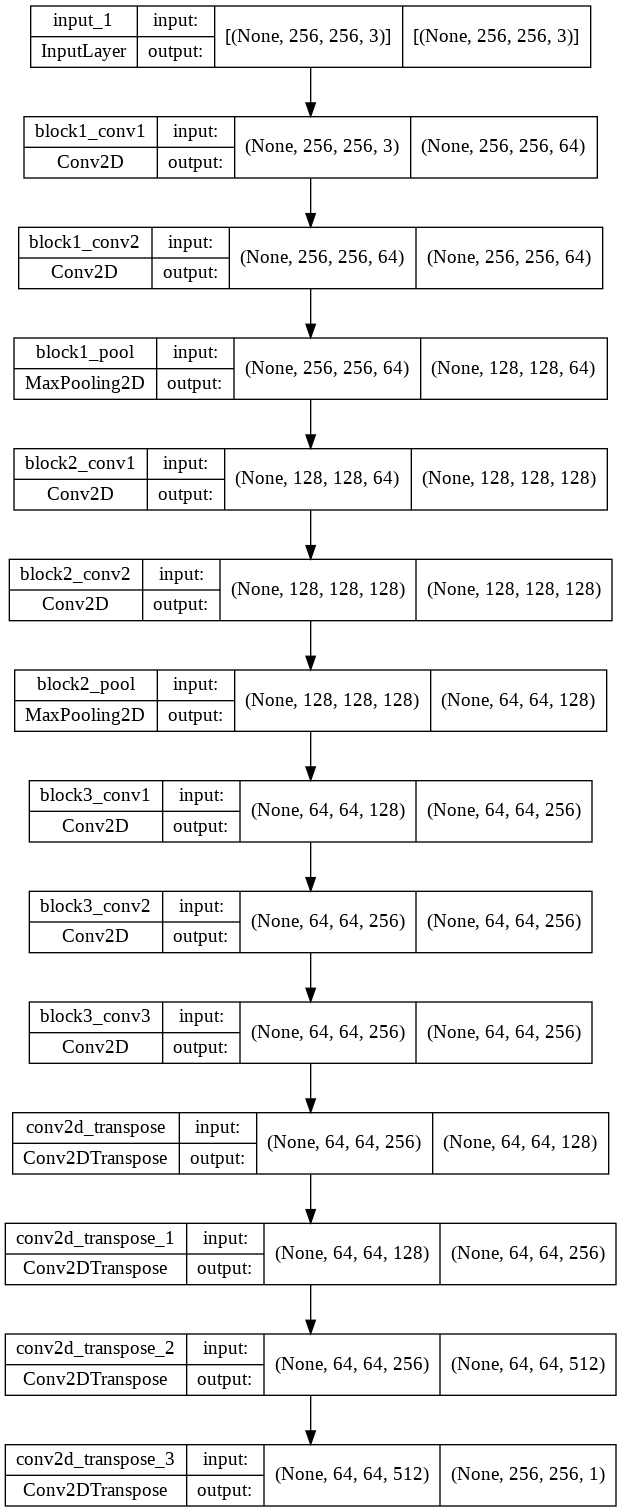

In [ ]:
# Take the first 10 layers
attention_model = tf.keras.Sequential(vgg_att_org.layers[:10])

Add deconvolutional blocks to complete the decoder
attention_model.add(keras.layers.Conv2DTranspose(128, kernel_size=4, padding="same", activation = "relu"))
attention_model.add(keras.layers.Conv2DTranspose(256, kernel_size=4, padding="same", activation = "relu"))
attention_model.add(keras.layers.Conv2DTranspose(512, kernel_size=4, padding="same", activation = "relu"))
attention_model.add(layers.Conv2DTranspose(1, kernel_size=4, strides=4, padding="same", activation="sigmoid"))
#attention_model.add(keras.layers.Conv2DTranspose(1, (16, 16), activation = 'sigmoid'))
#attention_model.add(keras.layers.Conv2D(3, (14, 14), activation = 'relu'))
#attention_model.add(keras.layers.Conv2D(1, (14, 14), activation = 'relu'))
#model.summary()

for layer in attention_model.layers[:10]:
    layer.trainable = False

keras.utils.plot_model(attention_model, show_shapes=True)

# Perceptual loss (Not done)

# Combine

input x = original image

seg + attention to find the areas of weather 

initial generator to change the entire image

finally combine all, i.e. only get the intersection of (seg / attention) * initital generator in the final output

In [ ]:
test_sunny = next(iter(val_sunny))

In [ ]:
#generator_g = keras.models.load_model(filepath=gen_model_save_dir)
#seg_model = keras.models.load_model(filepath=seg_model_save_dir)

test_sunny_prediction = generator_g(test_sunny)
seg_sunny_prediction = seg_model.predict(test_sunny)

print(test_sunny_prediction[0].shape)
print(seg_sunny_prediction[0].shape)

(256, 256, 3)
(256, 256, 3)


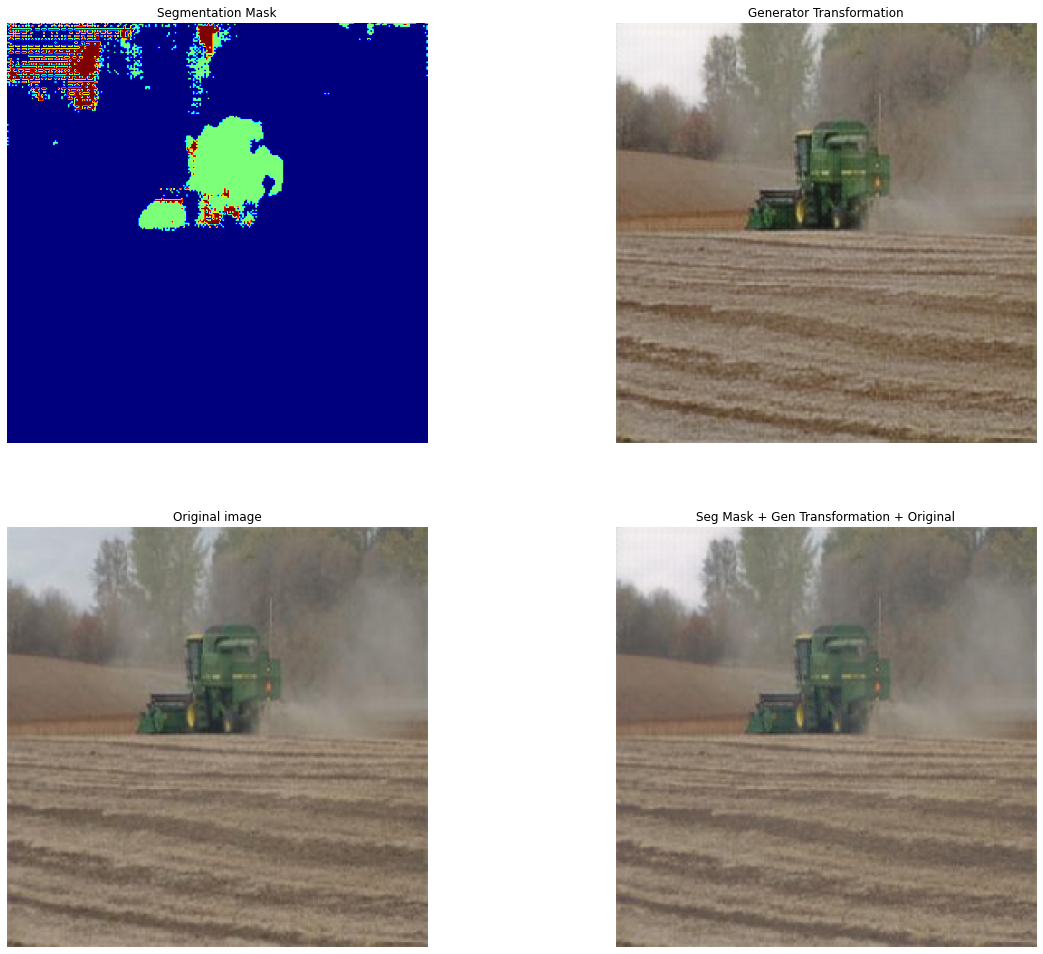

'# Adds a subplot at the 4th position\nfig.add_subplot(rows, columns, 4)\n  \n# showing image\nplt.imshow(Image4)\nplt.axis(\'off\')\nplt.title("Fourth")'

In [ ]:
fig = plt.figure(figsize=(20, 17))

k = 0

t1 = seg_sunny_prediction[k]
g1 = test_sunny_prediction[k]
x1 = test_sunny[k]

combine_test = tf.multiply(t1, g1) + tf.multiply((1-t1), tf.cast(x1, tf.float32))

fig.add_subplot(2,2,1)
i = tf.argmax(t1, axis=-1)
plt.imshow(i, cmap="jet")
plt.axis("off")
plt.title("Segmentation Mask")

fig.add_subplot(2,2,2)
plt.imshow(g1 * 0.5 + 0.5, cmap="jet")
plt.axis("off")
plt.title("Generator Transformation")

fig.add_subplot(2,2,3)
plt.imshow(x1 * 0.5 + 0.5 , cmap="jet")
plt.axis("off")
plt.title("Original image")

fig.add_subplot(2,2,4)
plt.imshow(combine_test * 0.5 + 0.5 , cmap="jet")
plt.axis("off")
plt.title("Seg Mask + Gen Transformation + Original")
plt.show()